# Taller de repaso: Aprendizaje no supervisado - parte 2

## Preparación del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
#!pip install kneed
from kneed import KneeLocator

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, FactorAnalysis

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset

In [3]:
# Lectura del dataset
df = pd.read_csv('https://raw.githubusercontent.com/mlondono-oc/LEA2_20232/main/Modulo3/data/train.csv')
df.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied


## Pre-procesamiento

In [4]:
# Eliminación de variables no significativas
df.drop(['Unnamed: 0', 'id', 'Arrival Delay in Minutes'], axis=1, inplace=True)

# Codificación de variable satisfacción
train_df1 = df.copy()
train_df1['satisfaction'] = train_df1['satisfaction'].map({'neutral or dissatisfied':0, 'satisfied':1})
train_df1['Gender'] = train_df1['Gender'].map({'Female':0, 'Male':1})
train_df1['Customer Type'] = train_df1['Customer Type'].map({'disloyal Customer':0, 'Loyal Customer':1})
train_df1['Type of Travel'] = train_df1['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
train_df1['Class'] = train_df1['Class'].map({'Eco':1, 'Eco Plus':2, 'Business':3})

# Escalado de variables numéricas
train_cols = train_df1[['Age', 'Flight Distance', 'Departure Delay in Minutes']]
scaler = StandardScaler()
scaled_train_df1 = pd.DataFrame(scaler.fit_transform(train_cols), columns = train_cols.columns)

#  Union de data numéricas  y categórica
cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
train_df1[cols] = scaled_train_df1

# Tratamiento de valores atípicos
train_df1_out = train_df1.copy()
# Take indices of all the outliers:
outs_idx=[train_df1_out[train_df1_out['Flight Distance'] > 2.5]['Flight Distance'].index.astype('int'),
          train_df1_out[train_df1_out['Departure Delay in Minutes'] > 20]['Departure Delay in Minutes'].index.astype('int')]

# Select unique ones and sort them:
outs_idx=pd.Series(sorted(np.concatenate(outs_idx))).unique()

# Drop these rows from 'train_df1_out' and 'train_df1, don't forget to RESET INDICES afterwards:
train_df1_out.drop(index=outs_idx,inplace=True)
train_df1_out.reset_index(drop=True,inplace=True) # 101174 rows left
train_df1_out.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,5,5,4,3,4,4,5,5,0.266393,0
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,1,1,1,5,3,1,4,1,-0.361375,0
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,5,5,4,3,4,4,4,5,-0.387532,1


## Reducción de la dimensionalidad

In [5]:
#Cree un dataset reducido que proporcione el 85% de la varianza de entrada que debe explicarse
pca = PCA(n_components=3).fit(train_df1_out)

#Por último, transforme "train_df1" de 22 columnas X_pca
X_pca = pca.fit_transform(train_df1_out)
X_pca[:3]

array([[-2.77993344,  1.52160144,  0.28847757],
       [ 4.15008755, -1.73781529, -1.16770528],
       [-2.93913087,  2.88145402,  0.86254294]])

In [6]:
df_final = train_df1_out.copy()
df_final['PCA1'] = X_pca[:,0]
df_final['PCA2'] = X_pca[:,1]
df_final['PCA3'] = X_pca[:,2]
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,3,4,4,5,5,0.266393,0,-2.779933,1.521601,0.288478
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,5,3,1,4,1,-0.361375,0,4.150088,-1.737815,-1.167705
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,3,4,4,4,5,-0.387532,1,-2.939131,2.881454,0.862543


Las loadings o cargas pueden interpretarse como el peso/importancia que tiene cada variable en cada componente y, por lo tanto, ayudan a conocer que tipo de información recoge cada una de las componentes.

In [7]:
# --- Pesos de las variables que componen las componentes principales ---
pesos_pca = pd.DataFrame(pca.components_, columns = train_df1_out.columns,
             index = ['PC 1', 'PC 2', 'PC 3']).round(2).T

pesos_pca

,PC 1,PC 2,PC 3
Gender,-0.00,-0.00,-0.01
Customer Type,-0.02,-0.01,0.01
Age,-0.05,0.00,0.05
Type of Travel,-0.03,0.02,0.00
Class,-0.13,0.04,-0.07
Flight Distance,-0.08,0.02,-0.02
Inflight wifi service,-0.26,-0.40,0.06
Departure/Arrival time convenient,-0.13,-0.50,0.00
Ease of Online booking,-0.21,-0.52,0.07
Gate location,-0.08,-0.37,0.07


## Modelo K-means

In [8]:
kmeans_constants = {"init": "random", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans.fit(X_pca)

KMeans(init='random', max_iter=500, n_clusters=4, n_init=100, random_state=42)

In [9]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  630507.9527428453
Silhouette Score:  0.2832637526992479
Calinski harabasz score:  45511.912245175045


In [10]:
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(X_pca)

df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3,Cluster_1
0,1,1,-1.745279,0,2,-0.731539,3,4,3,1,...,4,4,5,5,0.266393,0,-2.779933,1.521601,0.288478,1
1,1,0,-0.951360,1,3,-0.957184,3,2,3,3,...,3,1,4,1,-0.361375,0,4.150088,-1.737815,-1.167705,0
2,0,1,-0.885200,1,3,-0.047584,2,2,2,2,...,4,4,4,5,-0.387532,1,-2.939131,2.881454,0.862543,1


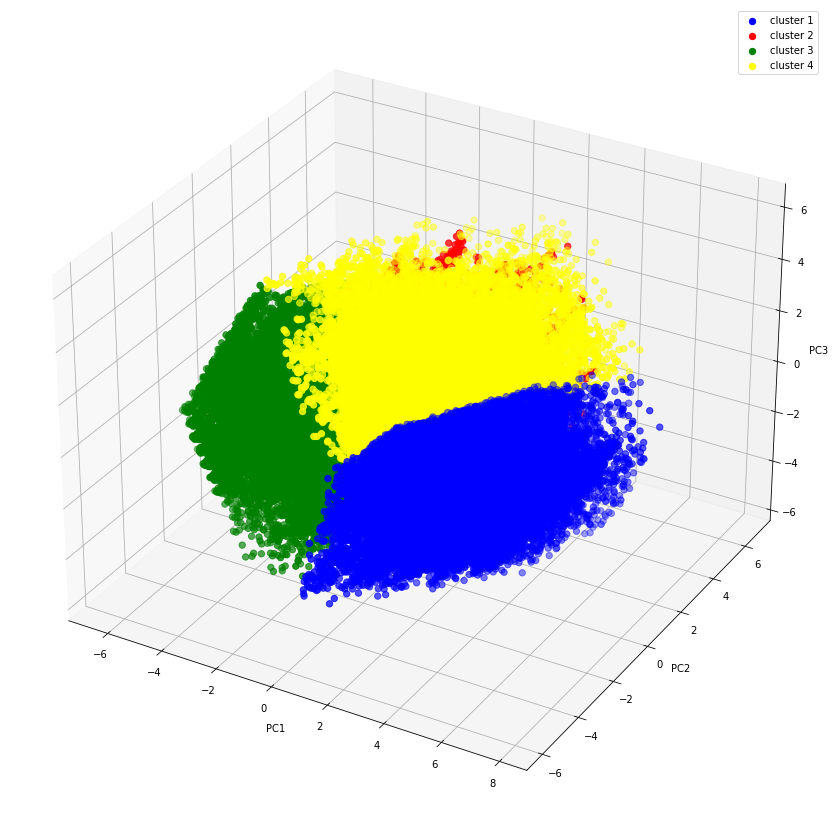

In [11]:
# 3d scatterplot using matplotlib
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_1 == 0,0],X_pca[Cluster_1 == 0,1],X_pca[Cluster_1 == 0,2], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca[Cluster_1 == 1,0],X_pca[Cluster_1 == 1,1],X_pca[Cluster_1 == 1,2], s = 40 , color = 'red', label = "cluster 2")
ax.scatter(X_pca[Cluster_1 == 2,0],X_pca[Cluster_1 == 2,1],X_pca[Cluster_1 == 2,2], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(X_pca[Cluster_1 == 3,0],X_pca[Cluster_1 == 3,1],X_pca[Cluster_1 == 3,2], s = 40 , color = 'yellow', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend()
plt.show()

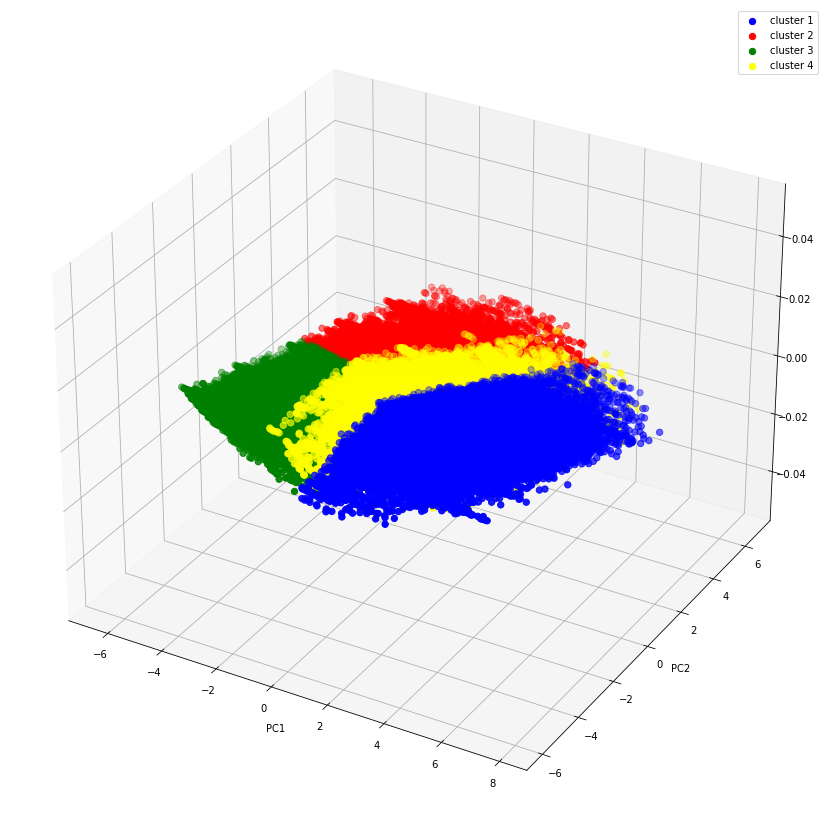

In [12]:
# 3d scatterplot using matplotlib
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[Cluster_1 == 0,0],X_pca[Cluster_1 == 0,1], s = 40 , color = 'blue', label = "cluster 1")
ax.scatter(X_pca[Cluster_1 == 1,0],X_pca[Cluster_1 == 1,1], s = 40 , color = 'red', label = "cluster 2")
ax.scatter(X_pca[Cluster_1 == 2,0],X_pca[Cluster_1 == 2,1], s = 40 , color = 'green', label = "cluster 3")
ax.scatter(X_pca[Cluster_1 == 3,0],X_pca[Cluster_1 == 3,1], s = 40 , color = 'yellow', label = "cluster 4")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

ax.legend()
plt.show()

## Interpretación clusters

In [13]:
# Conversión de variables numéricas a valores originales
train_cols = train_df1_out[['Age', 'Flight Distance', 'Departure Delay in Minutes']]
scaled_train_df1 = pd.DataFrame(scaler.inverse_transform(train_cols), columns = train_cols.columns)

# Union de data numéricas y categórica
cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
df_final[cols] = scaled_train_df1
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3,Cluster_1
0,1,1,13.0,0,2,460.0,3,4,3,1,...,4,4,5,5,25.0,0,-2.779933,1.521601,0.288478,1
1,1,0,25.0,1,3,235.0,3,2,3,3,...,3,1,4,1,1.0,0,4.150088,-1.737815,-1.167705,0
2,0,1,26.0,1,3,1142.0,2,2,2,2,...,4,4,4,5,0.0,1,-2.939131,2.881454,0.862543,1


<AxesSubplot:xlabel='Cluster_1', ylabel='count'>

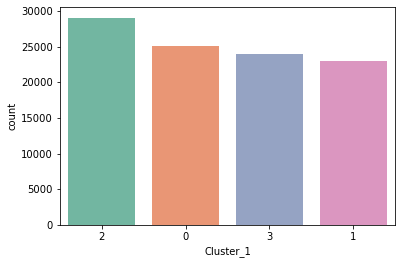

In [14]:
# Composición de los clusters formados
sns.countplot(x="Cluster_1",data=df_final, palette="Set2", order = df_final['Cluster_1'].value_counts().index)

In [15]:
# Composición de los clusters - Media de las variables por cluster
df_final.groupby(['Cluster_1']).mean()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3
Cluster_1,,,,,,,,,,,,,,,,,,,,,
0,0.540461,0.706888,33.693534,0.542733,1.590289,872.036156,2.306426,3.104799,2.498087,2.964442,...,3.248904,3.665391,3.067448,3.682532,1.732600,17.161923,0.140477,2.842670,-0.857314,-1.381802
1,0.493186,0.823872,40.132292,0.770573,2.294314,1257.564540,1.850217,1.981033,1.643880,2.047873,...,3.779818,4.139497,3.647613,4.165321,4.038194,12.858420,0.590365,-1.043634,2.548407,-0.535711
2,0.494836,0.880947,41.379157,0.776527,2.337293,1311.405564,3.953866,4.032225,3.945053,3.734421,...,3.900640,4.155856,3.691937,4.170764,3.907870,13.337637,0.727673,-2.633423,-1.309218,-0.173225
3,0.438588,0.829306,41.715024,0.626698,1.749479,1005.273477,2.533706,2.888134,2.641405,2.963461,...,2.337722,2.455879,2.732606,2.432922,3.404925,15.545996,0.194192,1.217587,0.034115,2.168076


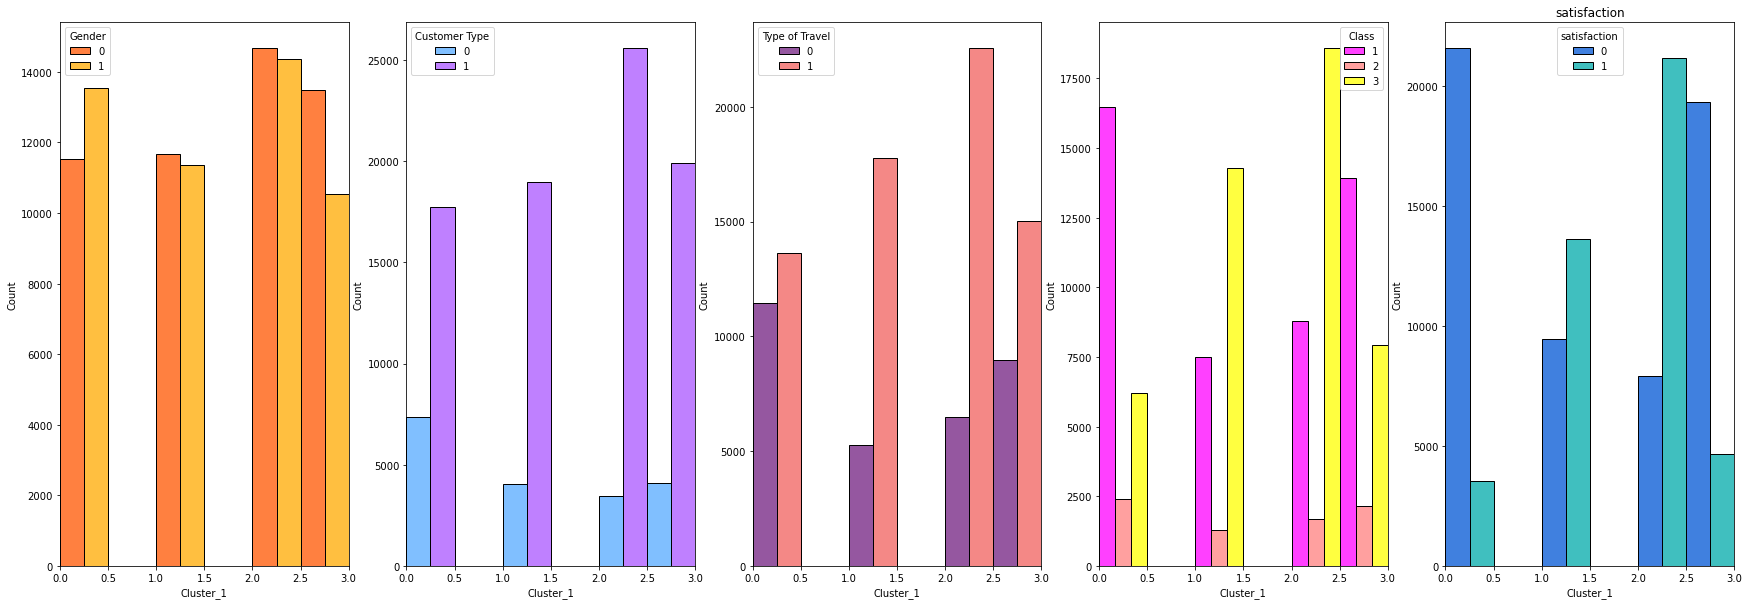

In [16]:
# Variables Categóricas
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

pal=['autumn','cool','magma','spring','winter'] # 5 color palettes for 5 categorical vars
    
fig,axs=plt.subplots(ncols=5,figsize =(30, 10))

for idx,i in enumerate(df_final[cat_cols].columns):
    plt.title(i)
    sns.histplot(data=df_final,x='Cluster_1', hue=i, palette=pal[idx], binwidth=.5, ax=axs[idx] ,multiple='dodge').set_xlim(0,3)

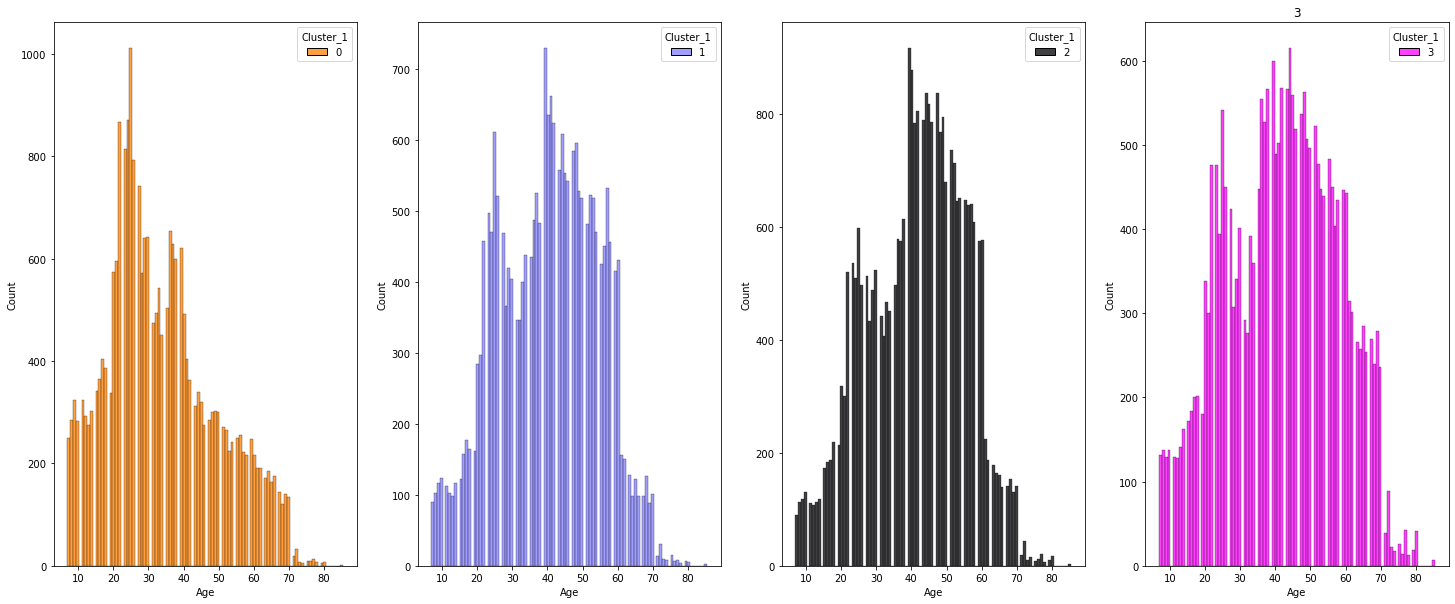

In [17]:
# Análisis de la edad
temp_edad = df_final[['Cluster_1','Age']]
fig,axs=plt.subplots(ncols=4,figsize =(25, 10))

for i in list(range(0,4)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='Age',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

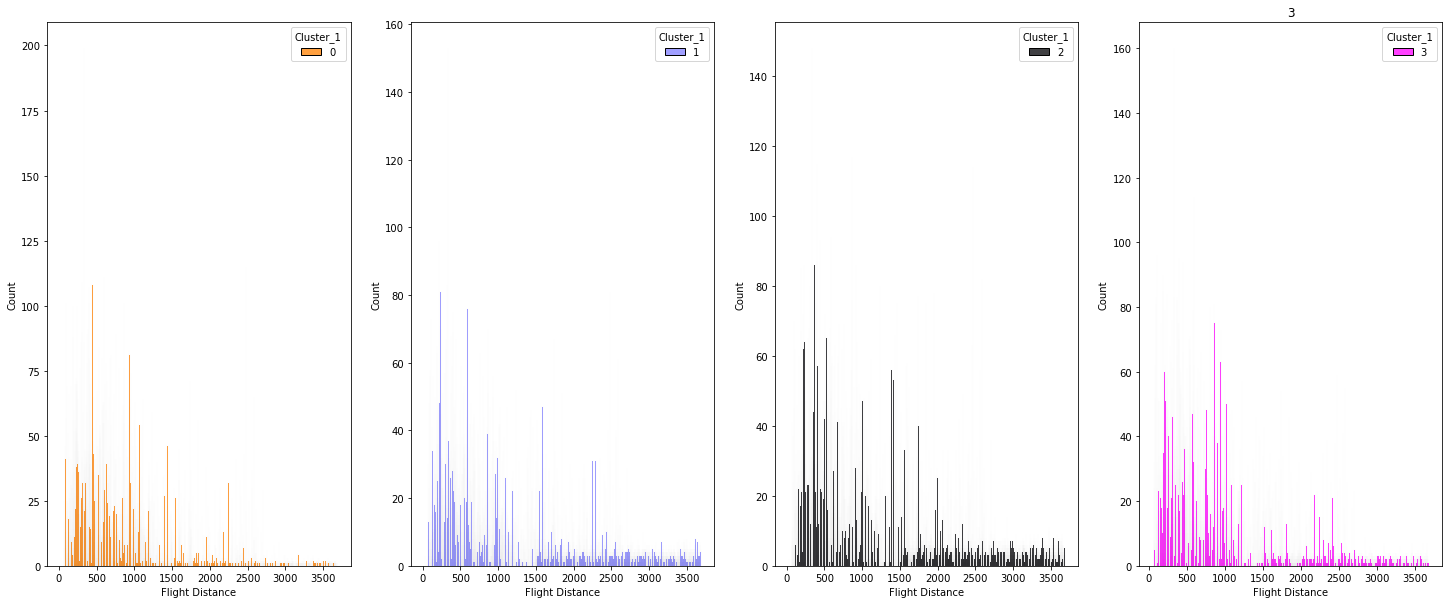

In [18]:
# Análisis de la distancia recorrida
temp_distancia = df_final[['Cluster_1','Flight Distance']]
fig,axs=plt.subplots(ncols=4,figsize =(25, 10))

for i in list(range(0,4)):
    plt.title(i)
    sns.histplot(data=temp_distancia[temp_distancia.Cluster_1==i],x='Flight Distance',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

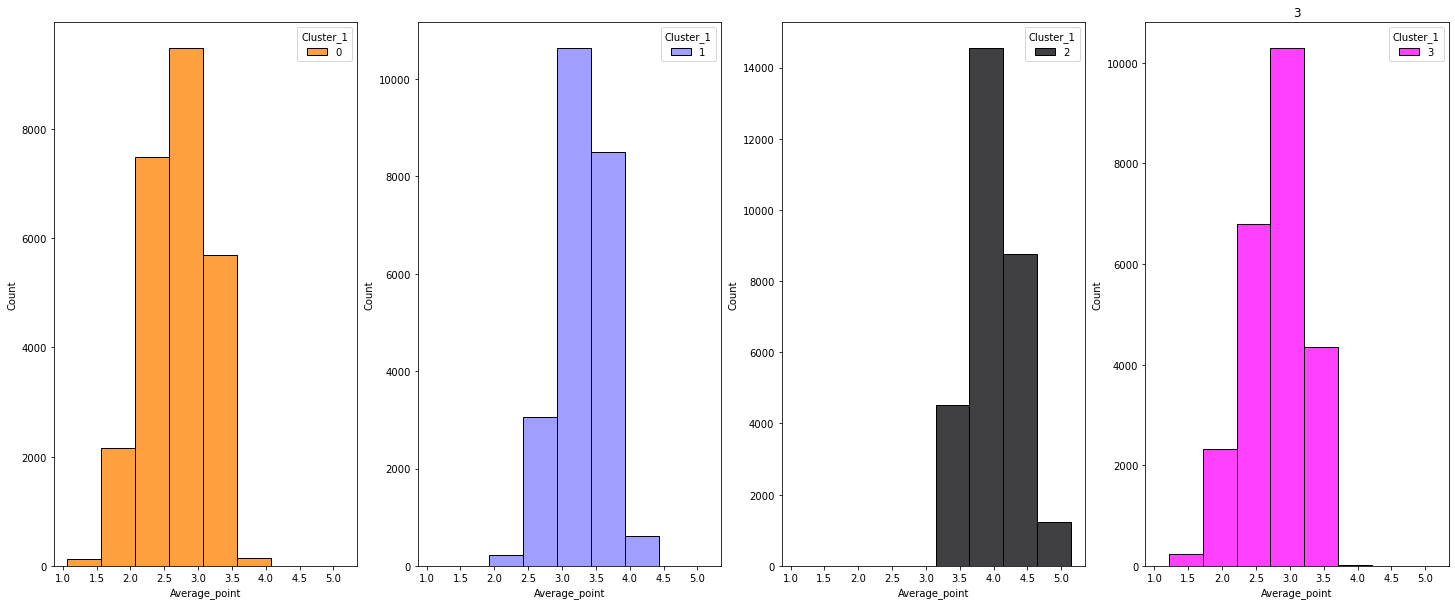

In [19]:
# Analisis de la encuesta
temp_encuesta = df_final.columns[6:20]
df_final["Average_point"]=round(df_final[temp_encuesta].mean(axis=1),3)

fig,axs=plt.subplots(ncols=4,figsize =(25, 10),sharex=True)

for i in list(range(0,4)):
    plt.title(i)
    sns.histplot(data=df_final[df_final.Cluster_1==i],x="Average_point",hue="Cluster_1",palette=pal[i],binwidth=.5,ax=axs[i],multiple='dodge')

In [20]:
df_final[df_final['Cluster_1']==3]['Customer Type'].value_counts(normalize=True)

1    0.829306
0    0.170694
Name: Customer Type, dtype: float64

###  Summary

**Cluster 0**
* Mayor proporcion de hombres que de mujeres
* La mayoría  de clientes son leales, pero en comparación con los otros cluster tiene mayor proporción de clientes desleales (29,3%).
* Proporción significativa de "viajes personales" (45,7%)
* Los asientos "Eco" representan el 66% de las reservas; los "Eco Plus" son los menos reservados
* La mayor proporción de pasajeros jóvenes (~20 años); la proporción de pasajeros de más edad disminuye constantemente hasta los mayores de 70 años
* Los pasajeros tienden a dar puntos de valoración bajos, con más frecuencia entre "2,5" y "3"; mientras que "4,0" suele ser la máxima
* las distancias de los vuelos aéreos no suelen superar las 2000 millas,  menos  viajes de larga distancia.
* Solo el 15% de los clientes estan satisfechos (peor resultado)

**Cluster 1**
* proporción casi igual entre mujeres y hombres
* La mayoría  de clientes son leales (82,4%)
* 3 veces más "viajes de negocios" que "viajes personales".
* Los asientos "Business" representan el 62% de las reservas; los "Eco Plus" son los menos reservados
* La mayoría de los pasajeros tiene entre 20 y 60 años
* Los pasajeros son conservadores a la hora de dar puntos en la clasificación: normalmente, las cifras se sitúan entre "2", "3" y "4".
* la mayoría de los viajes son de hasta 2.000 millas, pero también hay vuelos de más de 2.500 millas
* El 59% de los clientes estan satisfechos

**Cluster 2**
* proporción casi igual entre mujeres y hombres
* La mayoría  de clientes son leales (88,4%)
* 3 veces más "viajes de negocios" que "viajes personales".
* Los asientos "Business" representan el 64% de las reservas (mayor proporción entre clusters); los "Eco Plus" son los menos reservados
* La mayoría de los pasajeros tiene entre 40 y 60 años
* los pasajeros tienden a dar las puntuaciones más altas: casi todas se sitúan entre "3" y "5"
* la mayoría de los viajes son de hasta 1.000 millas
* El 73% de los clientes estan satisfechos (clientes mas satisfechos)

**Cluster 3**
* Mayor proporcion de mujeres que de hombres
* La mayoría  de clientes son leales (83%)
* 2 veces más "viajes de negocios" que "viajes personales".
* Los asientos "Eco" representan el 58% de las reservas (mayor proporción entre clusters); los "Eco Plus" son los menos reservados
* Mayor frecuencia de pasajeros mayores entre los 60 y 80 años 
* Los pasajeros tienden a dar puntos de valoración más bajos: entre "2" y "3", mientras que "3,5" suele ser la máxima
* El 19,4% de los clientes estan satisfechos


## Análisis de  factores

### Prueba de adecuación

La prueba de esfericidad de Bartlett verifica si las variables observadas se intercorrelacionan o no utilizando la matriz de correlación observada contra la matriz de identidad. Si la prueba resulta estadísticamente insignificante, no se debe emplear un análisis factorial.

En esta prueba de Bartlett, el valor p es 0. La prueba fue estadísticamente significativa, lo que indica que la matriz de correlación observada no es una matriz de identidad.

In [28]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Selección de variables de encuestas
df_fa = train_df1_out[train_df1_out.columns[6:20]] 

# Aplicación de la prueba bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_fa)
chi_square_value, p_value

(584586.2947206125, 0.0)

La prueba KMO mide la idoneidad de los datos para el análisis factorial. Determina la adecuación para cada variable observada y para el modelo completo. KMO estima la proporción de varianza entre todas las variables observadas. Una proporción más baja es más adecuada para el análisis factorial. Los valores de KMO oscilan entre 0 y 1. Un valor de KMO inferior a 0,6 se considera inadecuado.

El KMO general de nuestros datos es 0.78, lo cual es excelente. Este valor indica que puede continuar con el análisis factorial planificado.

In [29]:
from factor_analyzer.factor_analyzer import calculate_kmo

# Aplicación de la prueba KMO
kmo_all,kmo_model=calculate_kmo(df_fa)
kmo_model

0.7793352366502364

### Elección del número de factores

In [34]:
# Crear un objeto de análisis factorial y realizar un análisis factorial
fa = FactorAnalyzer(15, rotation=None)
fa.fit(df_fa)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([3.78130751, 2.34718325, 2.17217267, 1.07218015, 0.9542027 ,
       0.70896363, 0.54885542, 0.5168895 , 0.47142864, 0.37337728,
       0.32303185, 0.29191353, 0.25220942, 0.18628446])

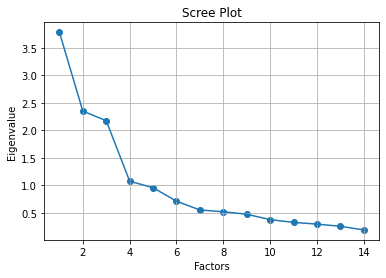

In [36]:
# Diagrama con valores propios
plt.scatter(range(1,df_fa.shape[1]+1),ev)
plt.plot(range(1,df_fa.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Aquí sólo utilizaremos 3 factores, dada la gran caída del valor propio después del tercer factor. Veamos qué factores se crean y qué variables contienen.

### Aplicación de análisis factorial

In [40]:
# Analisis factorial
fa = FactorAnalyzer(3, rotation='varimax')
fa.fit(df_fa)

# Cargas
loads = fa.loadings_

# Cargas por cada variable y factor
print(pd.DataFrame(fa.loadings_,index=df_fa.columns))

                                          0         1         2
Inflight wifi service              0.166638  0.127121  0.758159
Departure/Arrival time convenient -0.029711  0.063279  0.487285
Ease of Online booking             0.025504  0.020636  0.938834
Gate location                     -0.034864 -0.031078  0.487337
Food and drink                     0.759749  0.010367  0.008344
Online boarding                    0.387231  0.110168  0.374504
Seat comfort                       0.789411  0.078953  0.030856
Inflight entertainment             0.752566  0.458540  0.013598
On-board service                   0.092036  0.696337  0.029200
Leg room service                   0.070796  0.472428  0.082174
Baggage handling                   0.020938  0.761618  0.026415
Checkin service                    0.137903  0.286158  0.029392
Inflight service                   0.015688  0.797221  0.016675
Cleanliness                        0.862579  0.086179  0.001383


He aquí los 3 factores, las variables que contienen y su posible "interpretabilidad":

* Comodidad: Comida y bebida, Comodidad del asiento, Entretenimiento a bordo, Limpieza

* Servicio: Servicio a bordo, Gestión de equipajes, Servicio a bordo

* Conveniencia: Wifi en vuelo, Comodidad de la hora de salida/llegada, Reserva en línea, Ubicación de la puerta de embarque.

In [41]:
# Varianza explicada por cada factor
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                         0         1         2
Variance          2.724437  2.263303  2.082065
Proportional Var  0.194603  0.161665  0.148719
Cumulative Var    0.194603  0.356267  0.504986


In [42]:
# Análisis de comunalidad
print(pd.DataFrame(fa.get_communalities(),index=df_fa.columns,columns=['Communalities']))

                                   Communalities
Inflight wifi service                   0.618733
Departure/Arrival time convenient       0.242334
Ease of Online booking                  0.882486
Gate location                           0.239678
Food and drink                          0.577396
Online boarding                         0.302338
Seat comfort                            0.630356
Inflight entertainment                  0.776800
On-board service                        0.494209
Leg room service                        0.234953
Baggage handling                        0.581198
Checkin service                         0.101768
Inflight service                        0.636086
Cleanliness                             0.751472


In [44]:
# Transformación del dataset
X_fa = fa.fit_transform(df_fa)
X_fa.shape

(101174, 3)